### Understanding the Data Structure
- Structure of dataset
- Verify integrity of data
- Data loading & Preprocessing

### Libraries used
* **NumPy (np)**: arrays and matrices.
* **Pandas (pd)**: data manipulation and analysis
* **TensorFlow (tf)**: train neural networks.
* **OS (os)**

### Directory listing
name of each folder corresponds to the class of images it contains.

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os

directory_path = './dataset/asl_dataset'
folders_list = []    
    
# Directory listing    
for item in os.listdir(directory_path):
    item_path = os.path.join(directory_path, item)
    if os.path.isfile(item_path):
        folders_list += [item]
    elif os.path.isdir(item_path):
        folders_list += [f'{item}:{len(os.listdir(item_path))}']        

print(f'Folders: {folders_list}')

Folders: ['0:70', '1:70', '2:70', '3:70', '4:70', '5:70', '6:70', '7:70', '8:70', '9:70', 'a:70', 'b:70', 'c:70', 'd:70', 'e:70', 'f:70', 'g:70', 'h:70', 'i:70', 'j:70', 'k:70', 'l:70', 'm:70', 'n:70', 'o:70', 'p:70', 'q:70', 'r:70', 's:70', 't:65', 'u:70', 'v:70', 'w:70', 'x:70', 'y:70', 'z:70']


### Data pipeline
**image_dataset_from_directory**: 
Images resized to img_size x img_size 
The data is loaded in batches of batch_size. 
Reduces computational overhead.

**Label Mode (label_mode)**: one-hot encoded

**Shuffling**

**Train/Validation/Test Splits**

In [27]:
# Parameters
batch_size = 32
img_size = 64
validation_split = 0.2
test_split = 0.1
seed = 123

# Load the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory_path, labels='inferred', label_mode='categorical', batch_size=batch_size,
    image_size=(img_size, img_size), shuffle=True, seed=seed
)

# Sizes for splitting
dataset_size = len(dataset)
val_size = int(validation_split * dataset_size)
test_size = int(test_split * dataset_size)
train_size = dataset_size - val_size - test_size

# Split dataset
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size).take(test_size)
validation_dataset = dataset.skip(train_size + test_size)


num_classes = len(dataset.class_names)

Found 2515 files belonging to 36 classes.


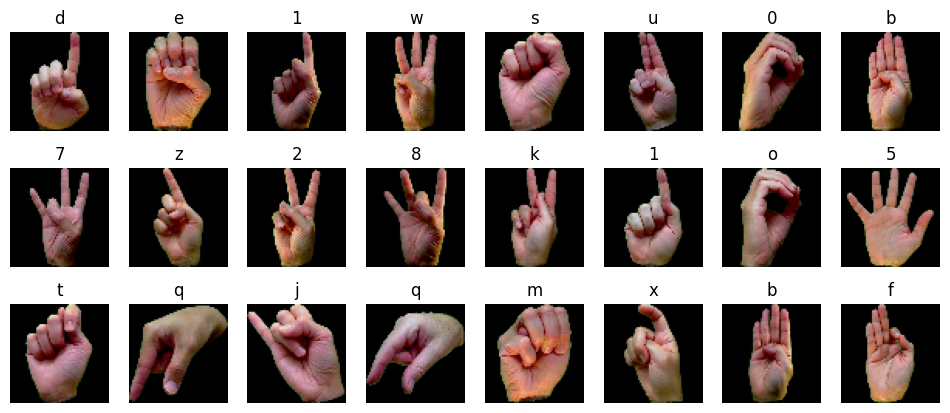

In [4]:
import matplotlib.pyplot as plt

class_names = dataset.class_names
images, labels = next(iter(dataset))
# Convert one-hot encoded labels to class indices
labels = tf.argmax(labels, axis=1)

plt.figure(figsize=(12, 5))
for i in range(24):
    plt.subplot(3, 8, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i].numpy()])
    plt.axis("off")

plt.show()

**Element Spec**: Shape and data types of both the images and labels.

In [15]:
print(dataset.element_spec)

for image, label in dataset.take(1):
    print("Image shape:", image.numpy().shape)
    print("Label shape:", label.numpy().shape)
    print("Label values:", label.numpy())

(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 36), dtype=tf.float32, name=None))
Image shape: (32, 64, 64, 3)
Label shape: (32, 36)
Label values: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [6]:
from keras import layers, Model

def create_parallel_model():
    inputs = layers.Input(shape=(img_size, img_size, 3))

    conv1 = layers.Conv2D(32, (3, 3), strides=(2, 2), activation='relu', padding='same', 
                          kernel_initializer='he_normal', bias_initializer='zeros')(inputs)
    conv2 = layers.Conv2D(32, (5, 5), strides=(2, 2), activation='relu', padding='same', 
                          kernel_initializer='he_normal', bias_initializer='zeros')(inputs)
    conv3 = layers.Conv2D(32, (7, 7), strides=(2, 2), activation='relu', padding='same', 
                          kernel_initializer='he_normal', bias_initializer='zeros')(inputs)

    x = layers.Concatenate()([conv1, conv2, conv3])

    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=2)(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(64, (3, 3), strides=(2, 2), activation='relu', padding='same', 
                      kernel_initializer='he_normal', bias_initializer='zeros')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=2)(x)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='Softmax',
                           kernel_initializer='glorot_uniform', bias_initializer='zeros')(x)

    return Model(inputs=inputs, outputs=outputs)

model = create_parallel_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      2,432 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │      4,736 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d[0][0],     │
│ (Concatenate)       │ 96)               │            │ conv2d_1[0][0],   │
│                     │                   │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        384 │ concatenate[0][0] │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 15, 15,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 15, 15,    │          0 │ max_pooling2d[0]… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 64)  │     55,360 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 4, 4, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ max_pooling2d_1[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Softmax (Dense)     │ (None, 36)        │      2,340 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 66,404 (259.39 KB)

 Trainable params: 66,084 (258.14 KB)

 Non-trainable params: 320 (1.25 KB)

### Model Architecture
* **Understanding Data Flow**
* **Layer Connections**
* **Debugging**

### Training the Model

In [7]:
parallel_history = model.fit(train_dataset, epochs=20, verbose=2, validation_data=validation_dataset)

Epoch 1/20
57/57 - 3s - 57ms/step - accuracy: 0.2220 - loss: 3.1006 - val_accuracy: 0.1392 - val_loss: 3.2204
Epoch 2/20
57/57 - 2s - 32ms/step - accuracy: 0.4923 - loss: 2.2867 - val_accuracy: 0.5118 - val_loss: 2.0919
Epoch 3/20
57/57 - 2s - 36ms/step - accuracy: 0.6820 - loss: 1.7881 - val_accuracy: 0.6360 - val_loss: 1.7653
Epoch 4/20
57/57 - 2s - 35ms/step - accuracy: 0.7719 - loss: 1.4134 - val_accuracy: 0.7409 - val_loss: 1.5162
Epoch 5/20
57/57 - 2s - 35ms/step - accuracy: 0.8295 - loss: 1.1339 - val_accuracy: 0.7430 - val_loss: 1.3342
Epoch 6/20
57/57 - 2s - 36ms/step - accuracy: 0.8717 - loss: 0.9078 - val_accuracy: 0.7923 - val_loss: 1.1520
Epoch 7/20
57/57 - 2s - 36ms/step - accuracy: 0.8991 - loss: 0.7421 - val_accuracy: 0.8822 - val_loss: 0.8644
Epoch 8/20
57/57 - 3s - 52ms/step - accuracy: 0.9260 - loss: 0.6216 - val_accuracy: 0.8887 - val_loss: 0.7918
Epoch 9/20
57/57 - 5s - 87ms/step - accuracy: 0.9364 - loss: 0.5134 - val_accuracy: 0.8994 - val_loss: 0.6405
Epoch 10/2

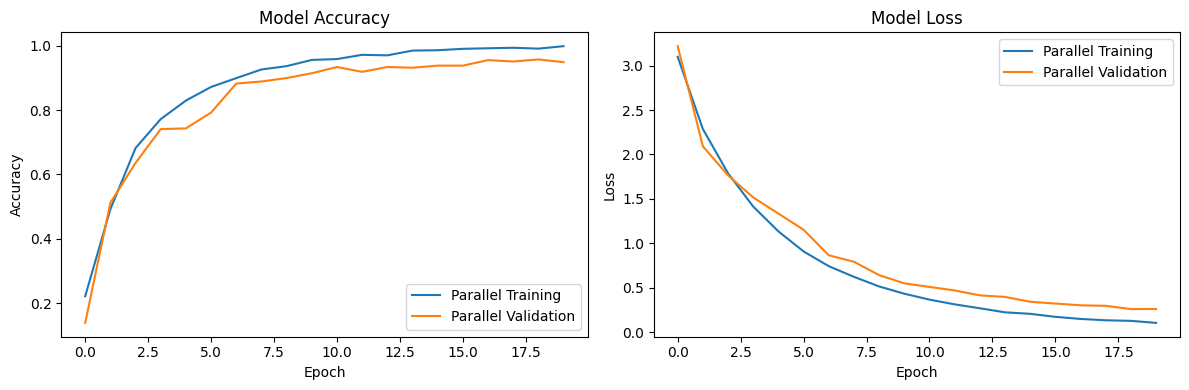

In [8]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(parallel_history.history['accuracy'], label='Parallel Training')
plt.plot(parallel_history.history['val_accuracy'], label='Parallel Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(parallel_history.history['loss'], label='Parallel Training')
plt.plot(parallel_history.history['val_loss'], label='Parallel Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Evaluating the Model

**Test Loss**: This value tells you how well the model minimizes errors on the test set. If the test loss is similar to the validation loss, it indicates that the model generalizes well to new data.

**Test Accuracy**: This metric shows the percentage of correct predictions on the test set. A high test accuracy suggests that the model has learned useful patterns that apply to unseen data.

In [16]:
test_loss, test_accuracy = model.evaluate(test_dataset)
parallel_test_loss, parallel_test_accuracy = model.evaluate(test_dataset)

print('Test Loss:')
print(f'   Parallel: {parallel_test_loss}')
print('Test Accuracy:')
print(f'   Parallel: {parallel_test_accuracy}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9766 - loss: 0.1452
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9821 - loss: 0.1913
Test Loss:
   Parallel: 0.17738601565361023
Test Accuracy:
   Parallel: 0.9821428656578064


### Visualizing Model Predictions on Test Data

The visualization step is not just about presentation but also serves as a tool for debugging and refining the model based on how well it generalizes to unseen data.

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


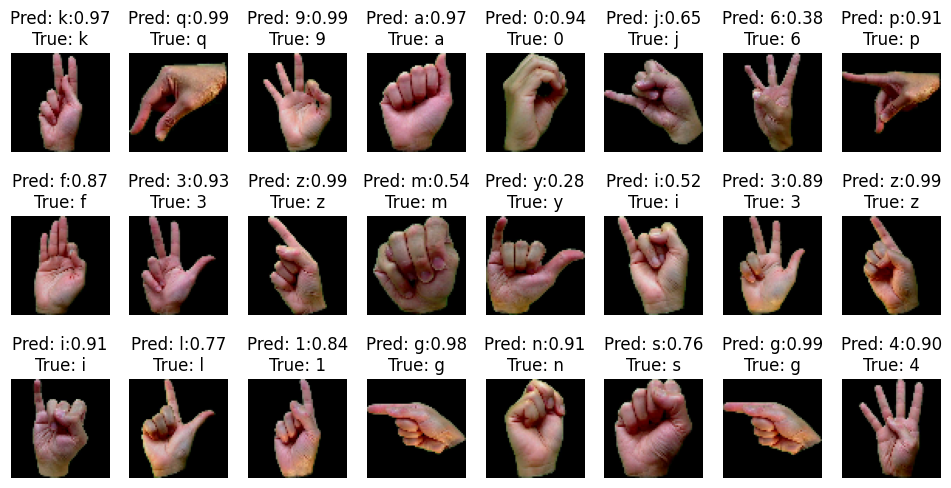

In [17]:
import numpy as np

all_images, all_true_labels = [], []

for images, labels in test_dataset:
    true_labels = np.argmax(labels, axis=1)
    
    all_images.extend(images.numpy())
    all_true_labels.extend(true_labels)

# Convert lists to numpy arrays
all_images = np.array(all_images)
all_true_labels = np.array(all_true_labels)

predictions = model.predict(all_images)
predicted_labels = np.argmax(predictions, axis=1)

class_names = dataset.class_names

# 24 examples
plt.figure(figsize=(12, 6))
for i in range(24):
    plt.subplot(3, 8, i + 1)
    plt.imshow(all_images[i].astype("uint8"))
    
    predicted_class = class_names[predicted_labels[i]]
    predicted_prob = np.max(predictions[i]) 
    true_class = class_names[all_true_labels[i]]
    
    plt.title(f"Pred: {predicted_class}:{predicted_prob:.2f}\nTrue: {true_class}")
    plt.axis("off")

plt.show()

### Visualizing the Confusion Matrix
The confusion matrix is a fundamental tool for evaluating the performance of classification models, offering a detailed breakdown of correct and incorrect predictions by class.

A confusion matrix is a table used to evaluate the performance of a classification algorithm. It shows the number of correct and incorrect predictions broken down by each class.
* **Rows (True Label)**: Represent the actual classes (true labels).
* **Columns (Predicted Label)**: Represent the predicted classes.

### Modules used
* **Seaborn (sns)**: A powerful data visualization library built on top of Matplotlib, Seaborn provides a high-level interface for drawing attractive and informative statistical graphics, such as heatmaps.

* **Confusion Matrix (confusion_matrix)**: Part of the sklearn.metrics module, this function computes the confusion matrix, which is a summary of prediction results on a classification problem.

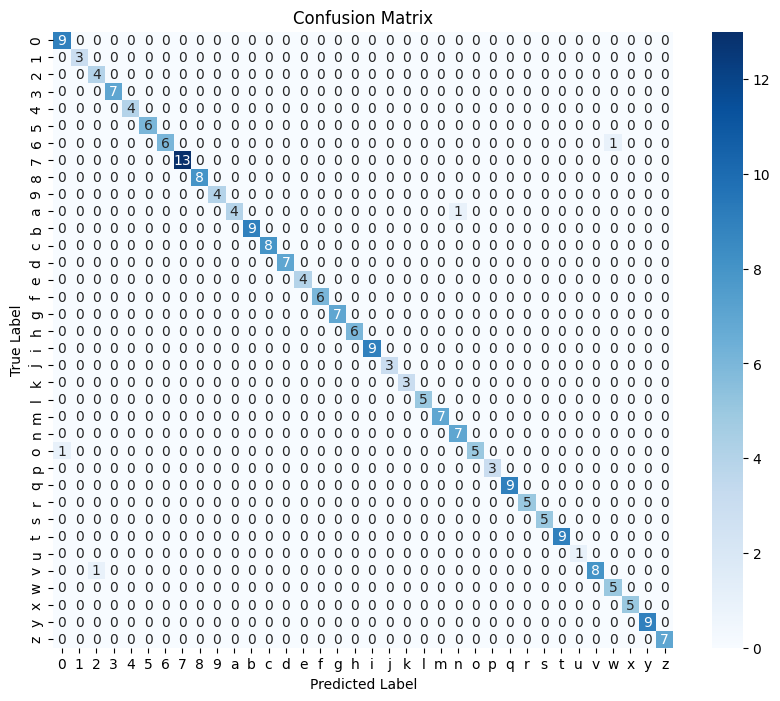

In [11]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [12]:
model.save("model.keras")
import joblib

joblib.dump(class_names, "class_names.pkl")

['class_names.pkl']

TO DO:
I think Im not able to pass singular images correctly to the model.
- when we pass a whole batch (32, 64, 64, 3) then it works fine
- but not with single image? (1, 64, 64, 3)

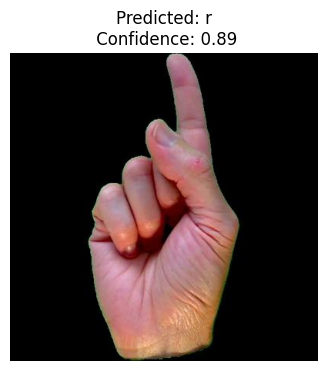

Predicted class: r
Confidence: 0.89


In [26]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt

def predict_image(model, img_path, class_names):
    img = load_img(img_path, target_size=(64, 64))
    img_array = img_to_array(img)
    img_array = img_array.astype('float32') / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)    # Add batch dimension: (1, 64, 64, 3)
    
    # Make prediction
    predictions = model.predict(img_array, verbose=0)
    predicted_class_index = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_index] 
    predicted_class = class_names[predicted_class_index]
    
    plt.figure(figsize=(4, 4))
    plt.imshow(load_img(img_path))
    plt.title(f"Predicted: {predicted_class}\n Confidence: {confidence:.2f}")
    plt.axis("off")
    plt.show()
    return predicted_class, confidence

img_path = "dataset/asl_dataset/1/hand1_1_bot_seg_1_cropped.jpeg"
predicted_class, confidence = predict_image(model, img_path, class_names)
print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence:.2f}")